In [241]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from quantum_logical import Pulse, DressedQuantumSystem
from quantum_logical.hamiltonian import QubitSNAILModule
from quantum_logical.mode import QubitMode, SNAILMode
from qutip import Options

from tqdm import tqdm
from scipy.optimize import minimize
import scienceplots
import itertools

opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6}  # , "progress_bar": "text"}

In [242]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=snail_freq, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = DressedQuantumSystem(
    qubits + [snail], couplings=_couplings, hamiltonian_cls=QubitSNAILModule
)

# (undressed) expectation operators
e_ops = [qs.modes_num[m] for m in qs.modes]

# collapse operators
c_ops = []
# for mode in qs.modes:
#    c_ops.append(mode.collapse_operators(qs))

In [243]:
# create an initial state
mode_states = tuple([(qubit1, 0), (qubit2, 1), (qubit3, 0)])
psi0 = qs.prepare_approx_state(mode_states)
rho0 = psi0 * psi0.dag()

Found overlap with eigenstate by 0.9954


In [244]:
from qutip_qip.operations import iswap

desired_U = iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action to the complete system
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
# Skip the first two qubits as they're already included
# Skip the last index as it's the SNAIL mode
for mode in qs.modes[2:-1]:
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

# act on qubit space only
qubit_rho0 = rho0.ptrace(range(len(qubits)))
expected_qubit_rho = qt.Qobj(desired_U * qubit_rho0 * desired_U.dag())

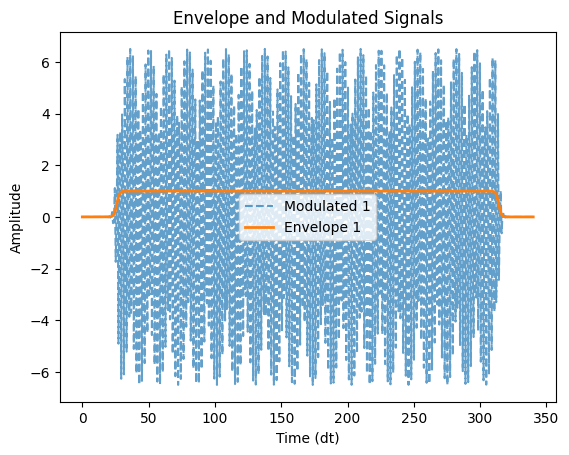

In [323]:
width_d = 300  # ns
off_d = 20
# args = {"shape": Pulse.box, "shape_params": {"t0": off_d, "width": width_d}}
args = {
    "shape": Pulse.smoothbox,
    "shape_params": {"t0": off_d, "width": width_d, "k": 0.5},
}
full_time = np.linspace(0, width_d + 2 * off_d, 500)
wp = np.abs(qubit1.freq - qubit2.freq)
pulse = Pulse(omega=wp, amp=6.5, phi=np.pi)

# Plot the Gaussian pulse shape
Pulse.plot_pulse([(pulse, args)], full_time)

In [166]:
def reduced_mesolve_task(omega_amp_tuple, initial_state=None, pump_phase=None):
    if initial_state is None:
        raise ValueError("initial state can't be none.")
    omega, amp = omega_amp_tuple
    pulse = Pulse(omega=omega, amp=amp, phi=pump_phase)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    result = qt.mesolve(H, initial_state, full_time, c_ops, options=opts, args=args)
    return result.states[-1]


def extract_state_fidelity(result_state, desired_state):
    qubit_state = result_state.ptrace(range(len(qubits)))
    fidelity = qt.fidelity(qubit_state, desired_state)
    return fidelity


# NOTE
# optimal pump_phase = -0.32

# random_state = sample_state(seed=1)
# desired_qubit_state = desired_state(random_state)
# detuning, amplitude = (8.333333333 * 2 * np.pi / 1000), 14.15
# for pump_phase in np.linspace(-0.3054, -0.3491, 25):
#     fid = extract_state_fidelity(
#         reduced_mesolve_task((wp + detuning, amplitude), random_state, pump_phase),
#         desired_qubit_state,
#     )
#     print(f"fid: {fid:.7f}, pump_phase: {pump_phase:.4f}")

In [ ]:
# coarse-grain state fidelity sweep

amp_list = np.linspace(5, 20, 10)
detuning_list = np.linspace(5, 20, 10)  # Mhz
# convert detuning to rad/ns
omega_list = wp + (detuning_list * 2 * np.pi / 1000)
omega_amp_tuples = [(w, a) for w in omega_list for a in amp_list]

parallel_me_results = qt.parallel_map(
    reduced_mesolve_task,
    omega_amp_tuples,
    task_kwargs={"initial_state": psi0},
    progress_bar="text",
)

fidelity_list = []
for state in parallel_me_results:
    final_state = state.ptrace(range(len(qubits)))
    fidelity = qt.fidelity(final_state, expected_qubit_rho)
    fidelity_list.append(fidelity)

In [ ]:
# Transform fidelity_list to a 2D array
fidelity_array = np.array(fidelity_list).reshape(len(omega_list), len(amp_list))

# Use plt.style.context for the 'ipynb' style
with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size for better aesthetics

    # Plot the 2D color plot
    cax = ax.imshow(
        fidelity_array,
        extent=(amp_list[0], amp_list[-1], detuning_list[0], detuning_list[-1]),
        aspect="auto",
        origin="lower",
        cmap="viridis",
    )

    # Add a color bar
    cbar = fig.colorbar(cax)
    cbar.set_label("Fidelity")

    # Set axis labels
    ax.set_xlabel("Detuning (MHz)")
    ax.set_ylabel("Amplitude")

    # Set title
    ax.set_title("Fidelity of iSWAP gate")
    # Display the plot
    plt.show()

# extract best
# Find the index of the maximum fidelity value
best_fidelity_index = np.argmax(fidelity_array)

# Convert the flat index to a pair of indices for detuning and amplitude
omega_index, amp_index = np.unravel_index(best_fidelity_index, fidelity_array.shape)

# Retrieve the corresponding detuning and amplitude values
best_detuning = detuning_list[omega_index]
best_amplitude = amp_list[amp_index]
best_fidelity = fidelity_array[omega_index, amp_index]

# Print the results
print(f"Maximum Fidelity: {best_fidelity}")
print(f"Corresponding Detuning (MHz): {best_detuning}")
print(f"Corresponding Amplitude: {best_amplitude}")

In [326]:
best_detuning = 8.3333333
best_amplitude = 13.3333


def reduced_propagator_task(omega_amp_tuple):
    omega, amp = omega_amp_tuple
    pulse = Pulse(omega=omega, amp=amp)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    result = qt.propagator(H, full_time[-1], c_ops, args=args, options=opts)
    return result


U_prop = reduced_propagator_task((wp + best_detuning, best_amplitude))

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [150]:
def sample_state(seed=0):

    all_combinations = list(itertools.product([0, 1], repeat=len(qubits)))
    basis_states = []

    # prepare dressed basis states
    for comb in all_combinations:
        mode_states = tuple(
            (qubits[i], comb[i]) for i in range(len(qubits))
        )  # Convert to tuple for caching
        dressed_state = qs.prepare_approx_state(mode_states)
        basis_states.append(dressed_state)

    # randomly sample coefficients from [0, -1, +1, -i, +i]
    # return new normalized state
    np.random.seed(seed)
    coeffs = np.random.choice([0, 1, -1, 1j, -1j], size=len(basis_states))
    # coeffs = [0, 0, 1, 0, 0, 0, 0, 0]
    prepared_state = sum([c * s for c, s in zip(coeffs, basis_states)])
    return prepared_state / prepared_state.norm()


# don't forget for each new state need a new target state
def desired_state(prepared_psi0):
    qubit_rho0 = prepared_psi0.ptrace(range(len(qubits)))
    return qt.Qobj(desired_U * qubit_rho0 * desired_U.dag())


# random_state = sample_state()
# desired_qubit_state = desired_state(random_state)
# me_result_state = reduced_mesolve_task(random_state, (wp + 0.0535, 14.15))
# fid = extract_state_fidelity(me_result_state, desired_qubit_state)
# fid

In [ ]:
from scipy.optimize import minimize

# Define initial pulse parameters (omega, amplitude)
initial_detuning_guess = best_detuning * 2 * np.pi / 1000
initial_ampltiude_guess = best_amplitude
initial_pulse_params = [initial_detuning_guess, initial_ampltiude_guess]

# List to store fidelity values
fidelity_history = []


def cost_function(pulse_params):
    detuning, amplitude = pulse_params
    random_state = sample_state()
    desired_qubit_state = desired_state(random_state)
    me_result_state = reduced_mesolve_task(
        (wp + detuning, amplitude), initial_state=random_state
    )
    fid = extract_state_fidelity(me_result_state, desired_qubit_state)
    return 1 - fid


def callback(intermediate_result):
    detuning, amplitude = intermediate_result.x
    fid = 1 - intermediate_result.fun  # Convert cost back to fidelity
    fidelity_history.append(intermediate_result.fun)
    print(
        f"Fidelity = {fid}\n Parameters: Detuning = {detuning}, Amplitude = {amplitude}"
    )

In [ ]:
# Perform optimization using 'BFGS' method
result = minimize(
    cost_function,
    initial_pulse_params,
    method="Nelder-Mead",
    callback=callback,
    options={"disp": True},
)

# Extract optimized parameters
optimized_pulse_params = result.x
print("Optimized Parameters:", optimized_pulse_params)

# Plot fidelity over iterations
plt.plot(fidelity_history)
plt.xlabel("Iteration")
plt.ylabel("Infidelity")
plt.yscale("log")
plt.title("Fidelity vs. Iteration")
plt.grid(True)
plt.show()

In [ ]:
# construct full propagator to decide average gate fidelity
# need to build U by calling mesolve over each identity vector in the qubit basis
# then construct unitary from the column vectors
# create identity of size len(qubits)
_, eigenstates = qt.tensor(
    qt.identity(qubit_dim), qt.identity(qubit_dim), qt.identity(qubit_dim)
).eigenstates()
# iterate through the columns as states to pass to mesolve
initial_states = []
for eigenstate in eigenstates:
    initial_state = qt.tensor(eigenstate, qt.basis(snail.dim, 0))
    initial_states.append(initial_state)


# solve mesolve for each initial state
def fixed_pulse_mesolve_task(initial_state, omega_amp_tuple=None):
    omega, amp = omega_amp_tuple
    pulse = Pulse(omega=omega, amp=amp)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    result = qt.mesolve(H, initial_state, full_time, c_ops, options=opts, args=args)
    return result.states[-1]


result = qt.parallel_map(
    fixed_pulse_mesolve_task,
    initial_states,
    task_kwargs={"omega_amp_tuple": optimized_pulse_params},
)

# construct unitary by putting the column vectors together
unitary_columns = [state.full() for state in result]
propagator_unitary = np.column_stack(unitary_columns)

# calculate average gate fidelity
propagator_qubit_unitary = propagator_unitary.ptrace(range(len(qubits)))
average_gate_fidelity = qt.average_gate_fidelity(propagator_qubit_unitary, desired_U)
average_gate_fidelity

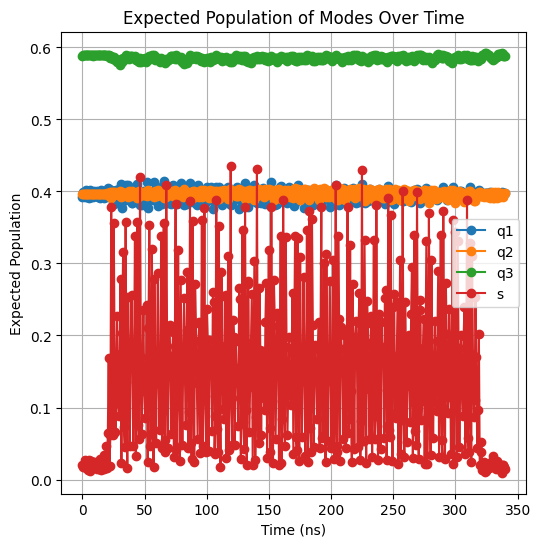

0.8349683199617337

In [157]:
def mesolve_task(initial_state, omega_amp_tuple):
    omega, amp = omega_amp_tuple
    pulse = Pulse(omega=omega, amp=amp, phi=-np.pi / 8)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": off_d, "width": width_d}}
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    result = qt.mesolve(H, initial_state, full_time, c_ops, options=opts, args=args)
    return [(t, state) for t, state in zip(result.times, result.states)]


def plot_expected_occupations(result_obj):
    # Prepare plot
    plt.figure(figsize=(6, 6))

    times = [t for t, _ in result_obj]

    # Collect data for all modes
    for mode in qs.modes_num:
        populations = [
            np.abs(qt.expect(qs.modes_num[mode], state)) for _, state in result_obj
        ]
        # Plot each mode's population over time
        plt.plot(times, populations, label=mode.name, marker="o")

    # Setting plot labels and title
    plt.xlabel("Time (ns)")
    plt.ylabel("Expected Population")
    plt.title("Expected Population of Modes Over Time")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


random_state = sample_state(seed=1)
detuning, amplitude = (8.333333333 * 2 * np.pi / 1000), 13.333333
desired_qubit_state = desired_state(random_state)
me_result = mesolve_task(random_state, (wp + detuning, amplitude))
me_result_state = me_result[-1][1]
plot_expected_occupations(me_result)
extract_state_fidelity(me_result_state, desired_qubit_state)